In [1]:
from keras.models import Model
from keras.layers import *

Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from __future__ import absolute_import
from recurrentshop import *

In [3]:
class RNNCell(Layer):

    def __init__(self, output_dim=None, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        self.output_dim = output_dim
        if 'batch_input_shape' in kwargs:
            self.model = self.build_model(kwargs['batch_input_shape'])
        elif 'input_shape' in kwargs:
            self.model = self.build_model((None,) + kwargs['input_shape'])
        if not hasattr(self, 'input_ndim'):
            self.input_ndim = 2
        super(RNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        if type(input_shape) is list:
            self.input_spec = [InputSpec(shape=shape) for shape in input_shape]
            self.model = self.build_model(input_shape[0])
        else:
            self.model = self.build_model(input_shape)
            self.input_spec = [InputSpec(shape=shape) for shape in _to_list(self.model.input_shape)]

    def build_model(self, input_shape):
        raise Exception(NotImplemented)

    @property
    def num_states(self):
        if hasattr(self, 'model'):
            model = self.model
        else:
            model = self.build_model((None,) + (2,) * (self.input_ndim - 1))  # Don't judge. It was 3 in the morning.
        model_input = model.input
        if type(model_input) is list:
            return len(model_input[1:])
        else:
            return 0

    @property
    def state_shape(self):
        model_input = self.model.input
        if type(model_input) is list:
            if len(model_input) == 2:
                return K.int_shape(model_input[1])
            else:
                return list(map(K.int_shape, model_input[1:]))
        else:
            return None

    def compute_output_shape(self, input_shape):
        model_inputs = self.model.input
        if type(model_inputs) is list and type(input_shape) is not list:
            input_shape = [input_shape] + list(map(K.int_shape, self.model.input[1:]))
        return self.model.compute_output_shape(input_shape)

    def call(self, inputs, learning=None):
        return self.model.call(inputs)

    def get_layer(self, **kwargs):
        input_shape = self.model.input_shape
        if type(input_shape) is list:
            state_shapes = input_shape[1:]
            input_shape = input_shape[0]
        else:
            state_shapes = []
        input = Input(batch_shape=input_shape)
        initial_states = [Input(batch_shape=shape) for shape in state_shapes]
        output = self.model([input] + initial_states)
        if type(output) is list:
            final_states = output[1:]
            output = output[0]
        else:
            final_states = []
        return RecurrentModel(input=input, output=output, initial_states=initial_states, final_states=final_states, **kwargs)

    @property
    def updates(self):
        return self.model.updates

    def add_update(self, updates, inputs=None):
        self.model.add_update(updates, inputs)

    @property
    def uses_learning_phase(self):
        return self.model.uses_learning_phase

    @property
    def _per_input_losses(self):
        if hasattr(self, 'model'):
            return getattr(self.model, '_per_input_losses', {})
        else:
            return {}

    @_per_input_losses.setter
    def _per_input_losses(self, val):
        if hasattr(self, 'model'):
            self.model._per_input_losses = val

    @property
    def losses(self):
        if hasattr(self, 'model'):
            return self.model.losses
        else:
            return []

    @losses.setter
    def losses(self, val):
        if hasattr(self, 'model'):
            self.model.losses = val

    def add_loss(self, losses, inputs=None):
        self.model.add_loss(losses, inputs)

    @property
    def constraints(self):
        return self.model.constraints

    @property
    def trainable_weights(self):
        return self.model.trainable_weights

    @property
    def non_trainable_weights(self):
        return self.model.non_trainable_weights

    def get_losses_for(self, inputs):
        return self.model.get_losses_for(inputs)

    def get_updates_for(self, inputs):
        return self.model.get_updates_for(inputs)

    def set_weights(self, weights):
        self.model.set_weights(weights)

    def get_weights(self):
        return self.model.get_weights()

    def get_config(self):
        config = {'output_dim': self.output_dim}
        base_config = super(RNNCell, self).get_config()
        config.update(base_config)
        return config

    def compute_mask(self, inputs, mask=None):
        model_output = self.model.output
        if type(model_output) is list:
            return [None] * len(model_output)
        else:
            return None

In [4]:
def _to_list(x):
    if type(x) is not list:
        x = [x]
    return x

def _is_rnn_cell(cell):
    return issubclass(cell.__class__, RNNCell)


def _is_all_none(iterable_or_element):
    if not isinstance(iterable_or_element, (list, tuple)):
        iterable = [iterable_or_element]
    else:
        iterable = iterable_or_element
    for element in iterable:
        if element is not None:
            return False
    return True

def _get_cell_input_shape(cell):
    if hasattr(cell, 'batch_input_shape'):
        cell_input_shape = cell.batch_input_shape
    elif hasattr(cell, 'input_shape'):
        cell_input_shape = cell.input_shape
    elif hasattr(cell, 'input_spec'):
        if isinstance(cell.input_spec, list):
            if hasattr(cell.input_spec[0], 'shape'):
                cell_input_shape = cell.input_spec[0].shape
            else:
                cell_input_shape = None
        else:
            if hasattr(cell.input_spec, 'shape'):
                cell_input_shape = cell.input_spec.shape
            else:
                cell_input_shape = None
    else:
        cell_input_shape = None

    if cell_input_shape is not None:
        if set(map(type, list(set(cell_input_shape) - set([None])))) != set([int]):
            cell_input_shape = cell_input_shape[0]

    return cell_input_shape

In [5]:
class RecurrentSequential(RecurrentModel):

    def __init__(self, state_sync=False, decode=False, output_length=None, return_states=False, readout=False, readout_activation='linear', teacher_force=False, state_initializer=None, **kwargs):
        self.state_sync = state_sync
        self.cells = []
        if decode and output_length is None:
            raise Exception('output_length should be specified for decoder')
        self.decode = decode
        self.output_length = output_length
        if decode:
            if output_length is None:
                raise Exception('output_length should be specified for decoder')
            kwargs['return_sequences'] = True
        self.return_states = return_states
        super(RecurrentModel, self).__init__(**kwargs)
        self.readout = readout
        self.readout_activation = activations.get(readout_activation)
        self.teacher_force = teacher_force
        self._optional_input_placeholders = {}
        if state_initializer:
            if type(state_initializer) in [list, tuple]:
                state_initializer = [initializers.get(init) if init else initializers.get('zeros') for init in state_initializer]
            else:
                state_initializer = initializers.get(state_initializer)
        self._state_initializer = state_initializer

    @property
    def state_initializer(self):
        if self._state_initializer is None:
            return None
        elif type(self._state_initializer) is list:
            return self._state_initializer + [initializers.get('zeros')] * (self.num_states - len(self._state_initializer))
        else:
            return [self._state_initializer] * self.num_states

    @state_initializer.setter
    def state_initializer(self, value):
        self._state_initializer = value

    @property
    def num_states(self):
        if hasattr(self, 'model'):
            return super(RecurrentSequential, self).num_states
        num = 0
        for cell in self.cells:
            if _is_rnn_cell(cell):
                num += cell.num_states
                if self.state_sync:
                    break
        if self.readout:
            num += 1
        return num

    def add(self, cell):
        self.cells.append(cell)
        cell_input_shape = _get_cell_input_shape(cell)
        if len(self.cells) == 1:
            if len(self.cells) == 1:
                if self.decode:
                    self.input_spec = InputSpec(shape=cell_input_shape)
                else:
                    self.input_spec = InputSpec(shape=cell_input_shape[:1] + (None,) + cell_input_shape[1:])

        if cell_input_shape is not None:
            cell_input_shape = cell.batch_input_shape
            batch_size = cell_input_shape[0]
            if batch_size is not None:
                self.batch_size = batch_size
            if not self.stateful:
                self.states = [None] * self.num_states

    def build(self, input_shape):
        if hasattr(self, 'model'):
            del self.model
        # Try and get batch size for initializer
        if not hasattr(self, 'batch_size'):
            if hasattr(self, 'batch_input_shape'):
                batch_size = self.batch_input_shape[0]
                if batch_size is not None:
                    self.batch_size = batch_size
        if self.state_sync:
            if type(input_shape) is list:
                x_shape = input_shape[0]
                if not self.decode:
                    input_length = x_shape.pop(1)
                    if input_length is not None:
                        shape = list(self.input_spec.shape)
                        shape[1] = input_length
                        self.input_spec = InputSpec(shape=tuple(shape))
                input = Input(batch_shape=x_shape)
                initial_states = [Input(batch_shape=shape) for shape in input_shape[1:]]
            else:
                if not self.decode:
                    input_length = input_shape[1]
                    if input_length is not None:
                        shape = list(self.input_spec.shape)
                        shape[1] = input_length
                        self.input_spec = InputSpec(shape=tuple(shape))
                    input = Input(batch_shape=input_shape[:1] + input_shape[2:])
                else:
                    input = Input(batch_shape=input_shape)
                initial_states = []
            output = input
            final_states = initial_states[:]
            for cell in self.cells:
                if _is_rnn_cell(cell):
                    if not initial_states:
                        cell.build(K.int_shape(output))
                        initial_states = [Input(batch_shape=shape) for shape in _to_list(cell.state_shape)]
                        final_states = initial_states[:]
                    cell_out = cell([output] + final_states)
                    if type(cell_out) is not list:
                        cell_out = [cell_out]
                    output = cell_out[0]
                    final_states = cell_out[1:]
                else:
                    output = cell(output)
        else:
            if type(input_shape) is list:
                x_shape = input_shape[0]
                if not self.decode:
                    input_length = x_shape.pop(1)
                    if input_length is not None:
                        shape = list(self.input_spec.shape)
                        shape[1] = input_length
                        self.input_spec = InputSpec(shape=tuple(shape))
                input = Input(batch_shape=x_shape)
                initial_states = [Input(batch_shape=shape) for shape in input_shape[1:]]
                output = input
                final_states = []
                for cell in self.cells:
                    if _is_rnn_cell(cell):
                        cell_initial_states = initial_states[len(final_states): len(final_states) + cell.num_states]
                        cell_in = [output] + cell_initial_states
                        cell_out = _to_list(cell(cell_in))
                        output = cell_out[0]
                        final_states += cell_out[1:]
                    else:
                        output = cell(output)
            else:
                if not self.decode:
                    input_length = input_shape[1]
                    if input_length is not None:
                        shape = list(self.input_spec.shape)
                        shape[1] = input_length
                        self.input_spec = InputSpec(shape=tuple(shape))
                    input = Input(batch_shape=input_shape[:1] + input_shape[2:])
                else:
                    input = Input(batch_shape=input_shape)
                output = input
                initial_states = []
                final_states = []
                for cell in self.cells:
                    if _is_rnn_cell(cell):
                        cell.build(K.int_shape(output))
                        state_inputs = [Input(batch_shape=shape) for shape in _to_list(cell.state_shape)]
                        initial_states += state_inputs
                        cell_in = [output] + state_inputs
                        cell_out = _to_list(cell(cell_in))
                        output = cell_out[0]
                        final_states += cell_out[1:]
                    else:
                        output = cell(output)

        self.model = Model([input] + initial_states, [output] + final_states)
        self.states = [None] * len(initial_states)
        if self.readout:
            readout_input = Input(batch_shape=K.int_shape(output), name='readout_input')
            if self.readout_activation.__name__ == 'linear':
                readout = Lambda(lambda x: x + 0., output_shape=lambda s: s)(readout_input)
            else:
                readout = Activation(self.readout_activation)(readout_input)
            input = Input(batch_shape=K.int_shape(input))
            if self.readout in [True, 'add']:
                input_readout_merged = add([input, readout])
            elif self.readout in ['mul', 'multiply']:
                input_readout_merged = multiply([input, readout])
            elif self.readout in ['avg', 'average']:
                input_readout_merged = average([input, readout])
            elif self.readout in ['max', 'maximum']:
                input_readout_merged = maximum([input, readout])
            elif self.readout == 'readout_only':
                input_readout_merged = readout
            initial_states = [Input(batch_shape=K.int_shape(s)) for s in initial_states]
            output = _to_list(self.model([input_readout_merged] + initial_states))
            final_states = output[1:]
            output = output[0]
            self.model = Model([input] + initial_states + [readout_input], [output] + final_states)
            self.states.append(None)
        super(RecurrentSequential, self).build(input_shape)

    def get_config(self):
        config = {'cells': list(map(serialize, self.cells)),
                  'decode': self.decode,
                  'output_length': self.output_length,
                  'readout': self.readout,
                  'teacher_force': self.teacher_force,
                  'return_states': self.return_states,
                  'state_sync': self.state_sync,
                  'state_initializer': self._serialize_state_initializer(),
                  'readout_activation': activations.serialize(self.readout_activation)}
        base_config = super(RecurrentModel, self).get_config()
        config.update(base_config)
        return config

    @classmethod
    def from_config(cls, config, custom_objects={}):
        custom_objects.update(_get_cells())
        cells = config.pop('cells')
        rs = cls(**config)
        for cell_config in cells:
            cell = deserialize(cell_config, custom_objects)
            rs.add(cell)
        return rs


# Legacy
RecurrentContainer = RecurrentSequential

In [6]:
class LSTMCell(RNNCell):

    def build_model(self, input_shape):
        output_dim = self.output_dim
        input_dim = input_shape[-1]
        output_shape = (input_shape[0], output_dim)
        x = Input(batch_shape=input_shape)
        h_tm1 = Input(batch_shape=output_shape)
        c_tm1 = Input(batch_shape=output_shape)
        f = add([Dense(output_dim)(x), Dense(output_dim, use_bias=False)(h_tm1)])
        f = Activation('sigmoid')(f)
        i = add([Dense(output_dim)(x), Dense(output_dim, use_bias=False)(h_tm1)])
        i = Activation('sigmoid')(i)
        c_prime = add([Dense(output_dim)(x), Dense(output_dim, use_bias=False)(h_tm1)])
        c_prime = Activation('tanh')(c_prime)
        c = add([multiply([f, c_tm1]), multiply([i, c_prime])])
        c = Activation('tanh')(c)
        o = add([Dense(output_dim)(x), Dense(output_dim, use_bias=False)(h_tm1)])
        h = multiply([o, c])
        return Model([x, h_tm1, c_tm1], [h, h, c])

In [7]:
def SimpleSeq2Seq(output_dim, output_length, hidden_dim=None, input_shape=None,
                  batch_size=None, batch_input_shape=None, input_dim=None,
                  input_length=None, depth=1, dropout=0.0, unroll=False,
                  stateful=False):

    '''
    Simple model for sequence to sequence learning.
    The encoder encodes the input sequence to vector (called context vector)
    The decoder decodes the context vector in to a sequence of vectors.
    There is no one on one relation between the input and output sequence
    elements. The input sequence and output sequence may differ in length.
    Arguments:
    output_dim : Required output dimension.
    hidden_dim : The dimension of the internal representations of the model.
    output_length : Length of the required output sequence.
    depth : Used to create a deep Seq2seq model. For example, if depth = 3,
            there will be 3 LSTMs on the enoding side and 3 LSTMs on the
            decoding side. You can also specify depth as a tuple. For example,
            if depth = (4, 5), 4 LSTMs will be added to the encoding side and
            5 LSTMs will be added to the decoding side.
    dropout : Dropout probability in between layers.
    '''

    if isinstance(depth, int):
        depth = (depth, depth)
    if batch_input_shape:
        shape = batch_input_shape
    elif input_shape:
        shape = (batch_size,) + input_shape
    elif input_dim:
        if input_length:
            shape = (batch_size,) + (input_length,) + (input_dim,)
        else:
            shape = (batch_size,) + (None,) + (input_dim,)
    else:
        # TODO Proper error message
        raise TypeError
    if hidden_dim is None:
        hidden_dim = output_dim
    encoder = RecurrentSequential(unroll=unroll, stateful=stateful)
    encoder.add(LSTMCell(hidden_dim, batch_input_shape=(shape[0], shape[-1])))

    for _ in range(1, depth[0]):
        encoder.add(Dropout(dropout))
        encoder.add(LSTMCell(hidden_dim))

    decoder = RecurrentSequential(unroll=unroll, stateful=stateful,
                                  decode=True, output_length=output_length)
    decoder.add(Dropout(dropout, batch_input_shape=(shape[0], hidden_dim)))

    if depth[1] == 1:
        decoder.add(LSTMCell(output_dim))
    else:
        decoder.add(LSTMCell(hidden_dim))
        for _ in range(depth[1] - 2):
            decoder.add(Dropout(dropout))
            decoder.add(LSTMCell(hidden_dim))
    decoder.add(Dropout(dropout))
    decoder.add(LSTMCell(output_dim))

    _input = Input(batch_shape=shape)
    x = encoder(_input)
    output = decoder(x)
    return Model(_input, output)


In [8]:
import numpy as np
from keras.utils.test_utils import keras_test

# 读取数据

In [9]:
from __future__ import unicode_literals

import os

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def parse_page(x):
    x = x.split('_')
    return ' '.join(x[:-3]), x[-3], x[-2], x[-1]


def nan_fill_forward(x):
    for i in range(x.shape[0]):
        fill_val = None
        for j in range(x.shape[1] - 3, x.shape[1]):
            if np.isnan(x[i, j]) and fill_val is not None:
                x[i, j] = fill_val
            else:
                fill_val = x[i, j]
    return x

df = pd.read_csv('train_1.csv', encoding='utf-8')
df = df[1:1000]
date_cols = [i for i in df.columns if i != 'Page']

df['name'], df['project'], df['access'], df['agent'] = zip(*df['Page'].apply(parse_page))

df=df.fillna(0)

le = LabelEncoder()
df['project'] = le.fit_transform(df['project'])
df['access'] = le.fit_transform(df['access'])
df['agent'] = le.fit_transform(df['agent'])
df['page_id'] = le.fit_transform(df['Page'])

In [10]:
df_input=df.iloc[:,2:302]
df_output=df.iloc[:,302:502]

In [11]:
input_length = 1
input_dim = 300

output_length = 1
output_dim = 200

samples = len(df_input)
hidden_dim = 24

In [12]:
x = np.random.random((samples, input_length, input_dim))
y = np.random.random((samples, output_length, output_dim))
for i in range(samples):
    x[i,0,:]=df_input.iloc[i,:]
    y[i,0,:]=df_output.iloc[i,:]

In [13]:
def test_SimpleSeq2Seq():
    x = np.random.random((samples, input_length, input_dim))
    y = np.random.random((samples, output_length, output_dim))

    models = []
    models += [SimpleSeq2Seq(output_dim=output_dim, hidden_dim=hidden_dim, output_length=output_length, input_shape=(input_length, input_dim))]
    models += [SimpleSeq2Seq(output_dim=output_dim, hidden_dim=hidden_dim, output_length=output_length, input_shape=(input_length, input_dim), depth=2)]

    for model in models:
        model.compile(loss='mse', optimizer='sgd')
        model.fit(x, y, nb_epoch=1)

In [14]:
models = []
models += [SimpleSeq2Seq(output_dim=output_dim, hidden_dim=hidden_dim, output_length=output_length, input_shape=(input_length, input_dim), depth=1)]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py:1520: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'multiply_3/mul:0' shape=(?, 24) dtype=float32>, <tf.Tensor 'multiply_3/mul:0' shape=(?, 24) dtype=float32>, <tf.Tensor 'activation_4/Tanh:0' shape=(?, 24) dtype=float32>]
  ' Found: ' + str(self.outputs))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py:1520: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'recurrent_sequential_1/multiply_6/mul:0' shape=(?, 24) dtype=float32>, <tf.Tensor 'recurrent_sequential_1/multiply_6/mul:0' shape=(?, 24) dtype=float32>, <tf.Tensor 'recurrent_sequential_1/activation_8/Tanh:0' shape=(?, 24) dtype=float32>]
  ' Found: ' + str(self.outputs))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py:1520: UserWarning: The list of ou

In [15]:
for model in models:
    model.compile(loss='mse', optimizer='rmsprop')
    model.fit(x, y, nb_epoch=10,validation_split=0.2)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  app.launch_new_instance()


Train on 799 samples, validate on 200 samples
Epoch 1/10
799/799 [==============================] - 1s - loss: 686748.4866 - val_loss: 4642.5196
Epoch 2/10
799/799 [==============================] - 0s - loss: 651191.2167 - val_loss: 4569.6978
Epoch 3/10
799/799 [==============================] - 0s - loss: 588470.9779 - val_loss: 4510.7007
Epoch 4/10
799/799 [==============================] - 0s - loss: 560447.6400 - val_loss: 4425.9317
Epoch 5/10
799/799 [==============================] - 0s - loss: 520346.1972 - val_loss: 4409.2483
Epoch 6/10
799/799 [==============================] - 0s - loss: 504307.0932 - val_loss: 4407.3072
Epoch 7/10
799/799 [==============================] - 0s - loss: 465992.1801 - val_loss: 4450.8949
Epoch 8/10
799/799 [==============================] - 0s - loss: 453539.2327 - val_loss: 4490.0619
Epoch 9/10
799/799 [==============================] - 0s - loss: 425800.0572 - val_loss: 4529.9233
Epoch 10/10
799/799 [==============================] - 0s - los

In [16]:
for model in models:
    prediction=model.predict(x[0:1,:,:])
    print(prediction)

[[[  3.16474857e+01   1.00436195e+02   8.27380066e+01   7.99155941e-08
     6.11970291e+01   6.91042023e+01   6.15795670e+01   7.87636642e+01
     2.63067432e-05   8.78545570e+00   6.49742126e+01   5.35317230e+01
     5.99744034e+01   5.64250870e+01   5.90040588e+01   2.43583745e-05
     2.87276314e-04   6.86895752e+01   8.04883174e-11   3.83134232e+01
     6.34794769e+01   4.58445320e+01   3.25524635e+01   3.75659676e+01
     3.25103226e+01   2.20176697e+01   2.78410606e+01   2.66025982e+01
     3.79151649e+01   5.74656487e+01   4.64847374e+01   5.53482212e-04
     2.47990036e+01   1.93196106e+01   3.25448112e+01   4.99528122e+01
     2.13613338e+01   1.26445761e+01   2.74877300e+01   1.49913664e+01
     3.23365746e+01   3.56488953e+01   2.41668530e+01   2.84936085e+01
     2.14909954e+01   4.25980644e+01   5.62706528e+01   6.30698776e+01
     2.18139629e+01   2.09137077e+01   2.50861206e+01   3.22278938e+01
     2.49535828e+01   2.09677582e+01   2.58509827e+01   3.80659142e+01
     3

In [19]:
prediction_list=prediction.tolist()

In [31]:
y1=prediction[0,0,:].tolist()
y2=y[0,0,:]

In [32]:
import matplotlib.pyplot as plt

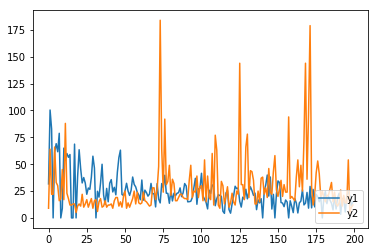

In [33]:
plt.plot(y1,label='y1')
plt.plot(y2,label='y2')
plt.legend(loc='lower right')
plt.show()